# Changes in US Industrial Production
Industrial production consists of manufacturing of durable and non-durable goods, mining (mining, quarrying, and oil and gas extraction), and production of utilities (electricity and natural gas). Different countries have a different share of industrial production in their GDP, with developed economies tending to have a smaller share of  industrial production in its GDP. In the US industrial production makes up 12% of the GDP and 24% of the GDP when accounting for its indirect effects.

Since industrial production is measured based on an index of production chained to a particular year, it communicates _real_ changes in production.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date

In [2]:
report_start = date.fromisoformat('1959-01-01')
report_end = date.today()

In [3]:
indpro_components = web.get_data_fred(['INDPRO', 'IPMANSICS', 'IPMINE', 'IPUTIL'], start=report_start, end=report_end)

In [4]:
INDPRO_SICS_COLUMN_NAME = 'Manufacturing'
INDPRO_MINE_COLUMN_NAME = 'Mining'
INDPRO_UTIL_COLUMN_NAME = 'Utilities'
GRAPH_TITLE_INDPRO_COMPOSITION = 'High-level Composition of US Indusrial Poduction'
indpro_components_stacked = indpro_components.rename(
    columns={'IPMANSICS': INDPRO_SICS_COLUMN_NAME,
             'IPMINE': INDPRO_MINE_COLUMN_NAME, 'IPUTIL': INDPRO_UTIL_COLUMN_NAME})

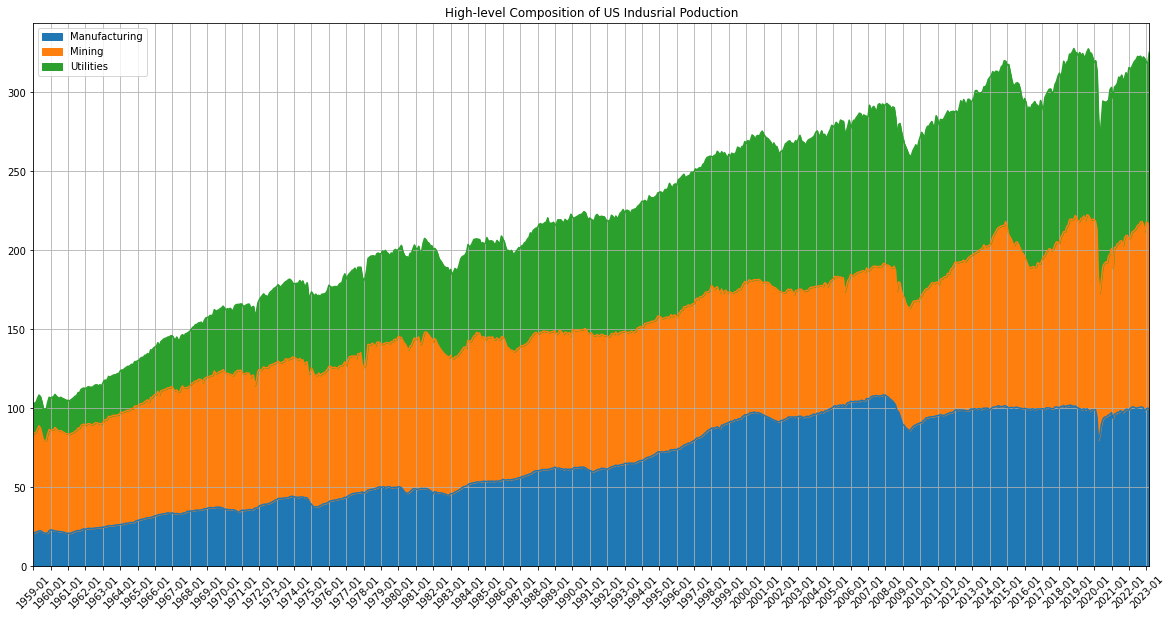

In [5]:
ax = indpro_components_stacked.iloc[:, 1:].plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_INDPRO_COMPOSITION,
                          xticks=indpro_components_stacked.index[::12], xlabel='', rot=45)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_components_stacked.index[::12])))

In [6]:
# Converting to percentages by dividing by total
indpro_components_stacked_pct = indpro_components_stacked.iloc[:,1:].divide(
    indpro_components_stacked.iloc[:,1:].sum(axis=1), axis=0)

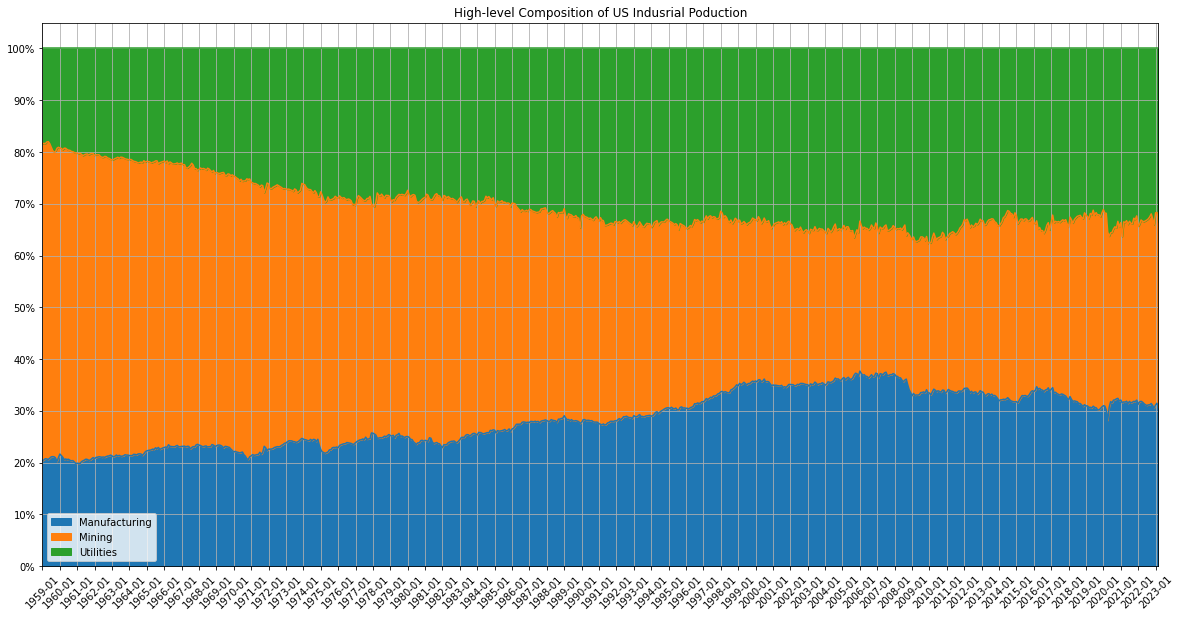

In [7]:
ax = indpro_components_stacked_pct.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_INDPRO_COMPOSITION,
                              xticks=indpro_components_stacked_pct.index[::12], xlabel='', rot=45,
                              yticks=np.arange(0, 1.01, .1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_components_stacked_pct.index[::12])))

In [8]:
# Converting to annual percentage changes (changes from the corresponding month a year ago)
indpro_components.update(indpro_components.pct_change(12))
indpro_components = indpro_components.loc['2003':]

In [9]:
INDPRO_COLUMN_NAME = 'Industrial Production Annual Percentage Change'
INDPRO_SICS_COLUMN_NAME = 'IP Manufacturing Annual Percentage Change'
INDPRO_MINE_COLUMN_NAME = 'IP Mining Annual Percentage Change'
INDPRO_UTIL_COLUMN_NAME = 'IP Utilities Annual Percentage Change'
GRAPH_TITLE_INDPRO_COMPONENTS = 'US Annual Percentage Changes in Main Components of Industrial Production'
indpro_components.rename(
    columns={'INDPRO': INDPRO_COLUMN_NAME, 'IPMANSICS': INDPRO_SICS_COLUMN_NAME,
             'IPMINE': INDPRO_MINE_COLUMN_NAME, 'IPUTIL': INDPRO_UTIL_COLUMN_NAME},
    inplace=True)

In [10]:
pd.options.display.float_format = '{:.4%}'.format
pd.options.display.max_rows = 20
indpro_components.loc['2020-01':]

,Industrial Production Annual Percentage Change,IP Manufacturing Annual Percentage Change,IP Mining Annual Percentage Change,IP Utilities Annual Percentage Change
DATE,,,,
2020-01-01,-1.9311%,-1.7694%,0.6832%,-5.0650%
2020-02-01,-1.1633%,-1.1030%,0.8666%,-3.0369%
2020-03-01,-5.0194%,-5.3894%,0.1466%,-6.7821%
2020-04-01,-17.2621%,-19.5397%,-14.8826%,-2.4608%
2020-05-01,-16.0575%,-16.0556%,-25.9864%,-5.4831%
...,...,...,...,...
2022-11-01,1.8526%,0.7740%,5.9272%,2.6207%
2022-12-01,0.5849%,-1.2611%,3.3988%,9.2040%
2023-01-01,1.3888%,0.7848%,9.2250%,-6.5479%


#### Zooming in on the last two years for better visualization

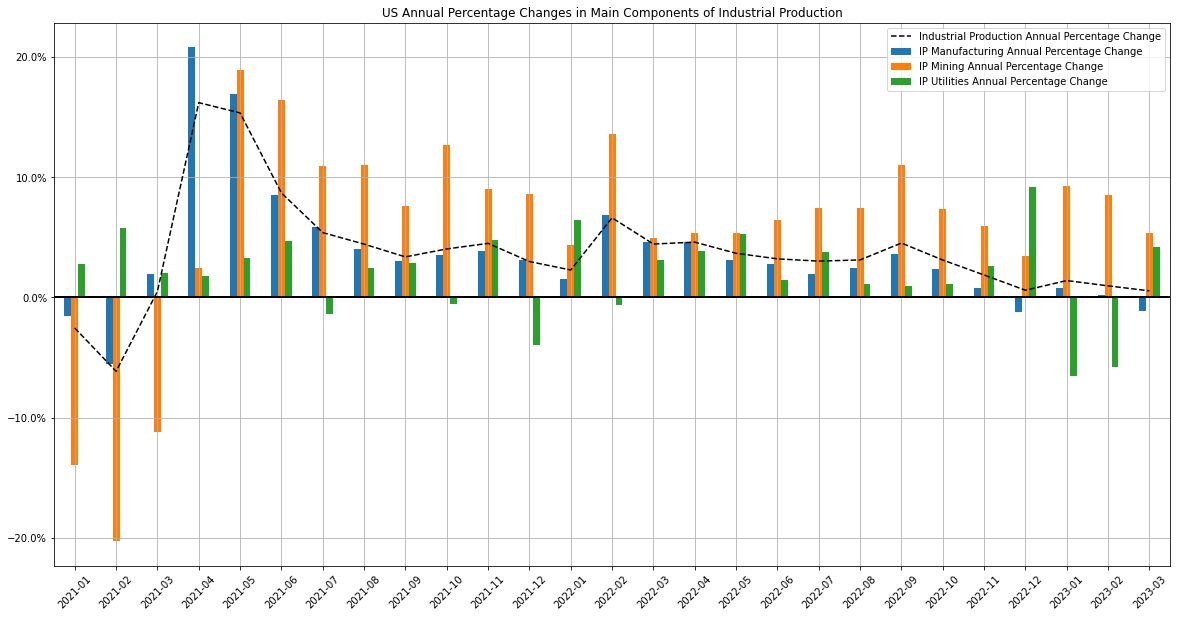

In [11]:
dt_from = date(2021, 1, 1)
indpro_components_recent = indpro_components.loc[dt_from:]
ax = indpro_components_recent.iloc[:,0].plot(figsize=(20,10), grid=True, title=GRAPH_TITLE_INDPRO_COMPONENTS,
                                          xlabel='', rot=45, linestyle='--', color='k', use_index=False)
indpro_components_recent.iloc[:,1:].plot.bar(ax=ax, grid=True, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_components_recent.index)))

### Zooming in on the Manufacturing Industry Group

In [12]:
ipman_components = web.get_data_fred(['IPDMAN', 'IPNMAN', 'IPGMFOS'], start=report_start, end=report_end)

# Converting to annual percentage changes (changes from the corresponding month a year ago)
ipman_components.update(ipman_components.pct_change(12))
ipman_components = ipman_components.loc['2003':]
ipman_components = pd.concat([indpro_components.iloc[:,1], ipman_components], axis=1)

In [13]:
IPDMAN_COLUMN_NAME = 'IP Durable Manufacturing Annual Percentage Change'
IPNMAN_COLUMN_NAME = 'IP Non-Durable Manufacturing Annual Percentage Change'
IPGMFOS_COLUMN_NAME = 'IP Other Manufacturing Annual Percentage Change'
GRAPH_TITLE_IPDMAN_COMPONENTS = 'US Annual Percentage Changes in Main Components of Manufacturing'
ipman_components.rename(
    columns={'IPDMAN': IPDMAN_COLUMN_NAME, 'IPNMAN': IPNMAN_COLUMN_NAME,
             'IPGMFOS': IPGMFOS_COLUMN_NAME},
    inplace=True)

In [14]:
ipman_components.loc['2020-01':]

,IP Manufacturing Annual Percentage Change,IP Durable Manufacturing Annual Percentage Change,IP Non-Durable Manufacturing Annual Percentage Change,IP Other Manufacturing Annual Percentage Change
DATE,,,,
2020-01-01,-1.7694%,-2.7665%,-0.8154%,0.4281%
2020-02-01,-1.1030%,-2.0077%,-0.0993%,-1.5229%
2020-03-01,-5.3894%,-8.8837%,-1.3950%,-7.1019%
2020-04-01,-19.5397%,-27.8086%,-10.1966%,-20.5412%
2020-05-01,-16.0556%,-22.4746%,-8.7324%,-18.2717%
...,...,...,...,...
2022-11-01,0.7740%,2.1428%,-0.3914%,-4.1583%
2022-12-01,-1.2611%,0.8159%,-3.1536%,-5.1999%
2023-01-01,0.7848%,1.8284%,-0.1006%,-3.1809%


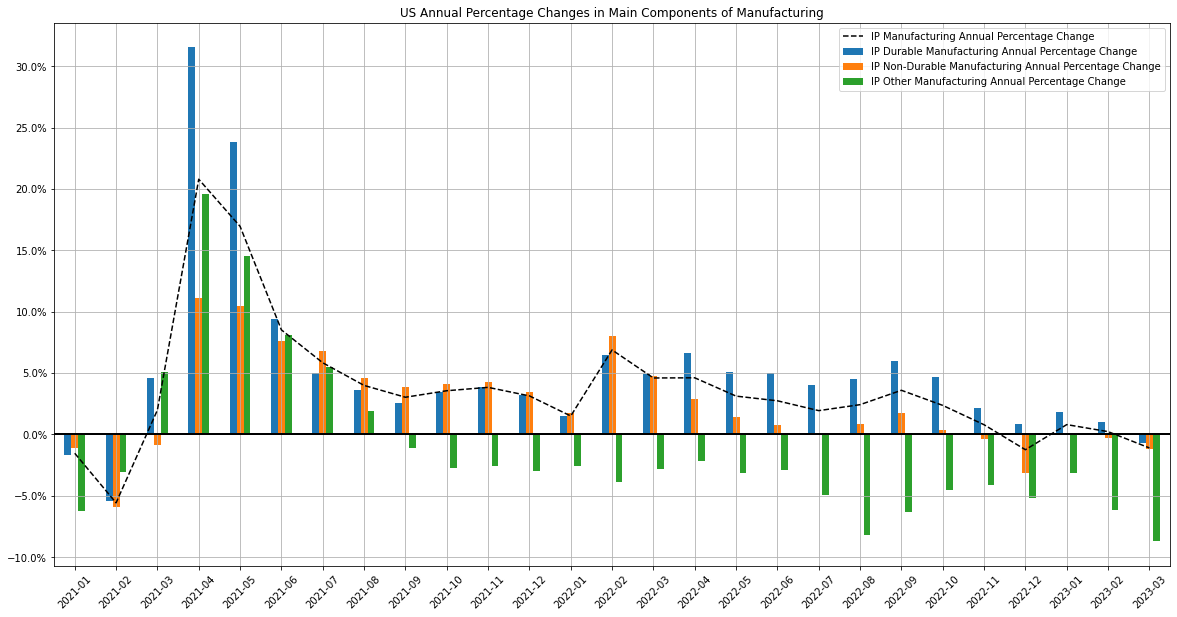

In [15]:
dt_from = date(2021, 1, 1)
ipman_components = ipman_components.loc[dt_from:]
ax = ipman_components.iloc[:,0].plot(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPDMAN_COMPONENTS,
                                          xlabel='', rot=45, linestyle='--', color='k', use_index=False)
ipman_components.iloc[:,1:].plot.bar(ax=ax, grid=True, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ipman_components.index)))

### Zooming in on the Durable Manufacturing Industry Group

In [16]:
ipdman_components = web.get_data_fred(['IPG321S', 'IPG327S', 'IPG331S', 'IPG332S', 'IPG333S',
                                       'IPG334S', 'IPG335S', 'IPG3361T3S', 'IPG3364T9S',
                                       'IPG337S', 'IPG339S'], start=report_start, end=report_end)
# dt_from_ipdman = date(1970, 1, 1)
# ipdman_components = ipdman_components.loc[dt_from_ipdman:]

In [17]:
IPDMAN_WP_COLUMN_NAME = 'Wood Products'
IPDMAN_NMMP_COLUMN_NAME = 'Nonmetallic Mineral Product'
IPDMAN_PM_COLUMN_NAME = 'Primary Metals'
IPDMAN_FMP_COLUMN_NAME = 'Fabricated Metal Products'
IPDMAN_M_COLUMN_NAME = 'Machinery'
IPNMAN_CEP_COLUMN_NAME = 'Computer and Electronic Products'
IPDMAN_EE_COLUMN_NAME = 'Electrical Equipment'
IPDMAN_MVP_COLUMN_NAME = 'Motor Vehicles and Parts'
IPDMAN_AS_COLUMN_NAME = 'Aerospace'
IPDMAN_F_COLUMN_NAME = 'Furniture'
IPDMAN_MSC_COLUMN_NAME = 'Miscellaneous'
GRAPH_TITLE_IPDMAN_COMPONENTS = 'US Composition of Durable Manufaturing Industry Group'
ipdman_components.rename(
    columns={'IPG321S': IPDMAN_WP_COLUMN_NAME, 'IPG327S': IPDMAN_NMMP_COLUMN_NAME,
             'IPG331S': IPDMAN_PM_COLUMN_NAME, 'IPG332S': IPDMAN_FMP_COLUMN_NAME,
             'IPG333S': IPDMAN_M_COLUMN_NAME, 'IPG334S': IPNMAN_CEP_COLUMN_NAME,
             'IPG335S': IPDMAN_EE_COLUMN_NAME, 'IPG3361T3S': IPDMAN_MVP_COLUMN_NAME,
             'IPG3364T9S': IPDMAN_AS_COLUMN_NAME, 'IPG337S': IPDMAN_F_COLUMN_NAME,
             'IPG339S': IPDMAN_MSC_COLUMN_NAME},
    inplace=True)

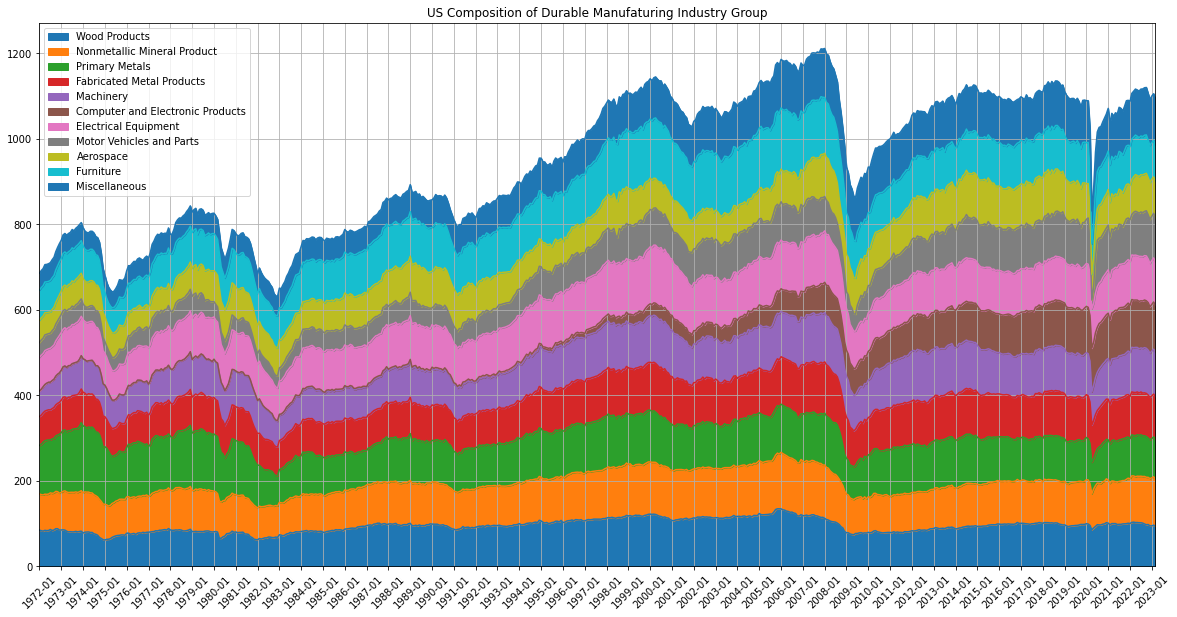

In [18]:
ax = ipdman_components.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPDMAN_COMPONENTS,
                          xticks=ipdman_components.index[::12], xlabel='', rot=45)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ipdman_components.index[::12])))

In [19]:
# Converting to percentages by dividing by total
ipdman_components_pct = ipdman_components.divide(ipdman_components.sum(axis=1), axis=0)

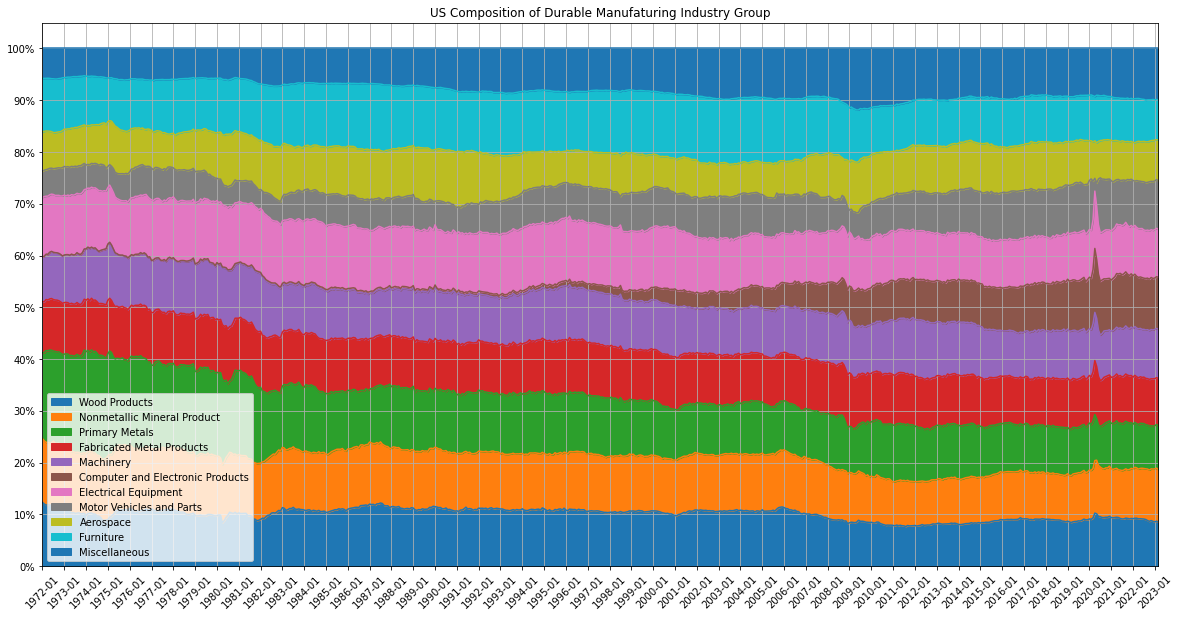

In [20]:
ax = ipdman_components_pct.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPDMAN_COMPONENTS,
                              xticks=ipdman_components_pct.index[::12], xlabel='', rot=45,
                              yticks=np.arange(0, 1.01, .1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ipdman_components_pct.index[::12])))